In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, MeanShift, AffinityPropagation, SpectralClustering
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import umap
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split


#reading the dataset from drive
data=pd.read_csv('Cost_of_Living_Index_by_Country_2024.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rank                            121 non-null    int64  
 1   Country                         121 non-null    object 
 2   Cost of Living Index            121 non-null    float64
 3   Rent Index                      121 non-null    float64
 4   Cost of Living Plus Rent Index  121 non-null    float64
 5   Groceries Index                 121 non-null    float64
 6   Restaurant Price Index          121 non-null    float64
 7   Local Purchasing Power Index    121 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 7.7+ KB


# Data Cleaning

In [20]:
# Handling missing values, encoding categorical variables, scaling numerical variables

# Identify columns with missing values
missing_values = data.isnull().sum()
missing_values.info()
# Impute missing values for numerical columns with median
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# Impute missing values for categorical columns with mode
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()
        if not mode_value.empty:
            data[col].fillna(mode_value[0], inplace=True)

# Encode the categorical 'Country' column
le = LabelEncoder()
data['Country_1'] = le.fit_transform(data['Country'])

# Select the features for clustering
features = data.drop(columns=['Rank','Country' ])  # Dropping 'Rank' , 'Country' as it's not a feature for clustering

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

data.head()

<class 'pandas.core.series.Series'>
Index: 8 entries, Rank to Local Purchasing Power Index
Series name: None
Non-Null Count  Dtype
--------------  -----
8 non-null      int64
dtypes: int64(1)
memory usage: 428.0+ bytes


,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Country_1
0,1,Switzerland,101.1,46.5,74.9,109.1,97.0,158.7,103
1,2,Bahamas,85.0,36.7,61.8,81.6,83.3,54.6,7
2,3,Iceland,83.0,39.2,62.0,88.4,86.8,120.3,45
3,4,Singapore,76.7,67.2,72.1,74.6,50.4,111.1,95
4,5,Barbados,76.6,19.0,48.9,80.8,69.4,43.5,10


# Exploratory Data Analysis

In [3]:
#To find missing values
data.count()

Rank                              121
Country                           121
Cost of Living Index              121
Rent Index                        121
Cost of Living Plus Rent Index    121
Groceries Index                   121
Restaurant Price Index            121
Local Purchasing Power Index      121
Country_1                         121
dtype: int64

In [4]:
#To find missing values
data.isnull().sum()

Rank                              0
Country                           0
Cost of Living Index              0
Rent Index                        0
Cost of Living Plus Rent Index    0
Groceries Index                   0
Restaurant Price Index            0
Local Purchasing Power Index      0
Country_1                         0
dtype: int64

In [5]:
#identify datatypes
data.dtypes

Rank                                int64
Country                            object
Cost of Living Index              float64
Rent Index                        float64
Cost of Living Plus Rent Index    float64
Groceries Index                   float64
Restaurant Price Index            float64
Local Purchasing Power Index      float64
Country_1                           int32
dtype: object

In [6]:
#describe features
data.describe()

,Rank,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Country_1
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,61.000000,43.555372,16.052893,30.357851,44.228926,36.471074,65.094215,60.000000
std,35.073732,16.147574,11.412267,13.263721,17.055109,18.258110,39.569094,35.073732
min,1.000000,18.800000,2.400000,11.100000,17.500000,12.800000,2.300000,0.000000
25%,31.000000,30.200000,8.500000,19.800000,31.600000,21.600000,34.800000,30.000000
50%,61.000000,39.500000,12.400000,27.000000,40.500000,33.100000,50.600000,60.000000
75%,91.000000,52.800000,20.100000,37.000000,53.700000,47.200000,99.400000,90.000000
max,121.000000,101.100000,67.200000,74.900000,109.100000,97.000000,182.500000,120.000000


In [7]:

#Identifying duplicate records
print(data.duplicated().sum())

0


In [8]:
data.head()

,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Country_1
0,1,Switzerland,101.1,46.5,74.9,109.1,97.0,158.7,103
1,2,Bahamas,85.0,36.7,61.8,81.6,83.3,54.6,7
2,3,Iceland,83.0,39.2,62.0,88.4,86.8,120.3,45
3,4,Singapore,76.7,67.2,72.1,74.6,50.4,111.1,95
4,5,Barbados,76.6,19.0,48.9,80.8,69.4,43.5,10


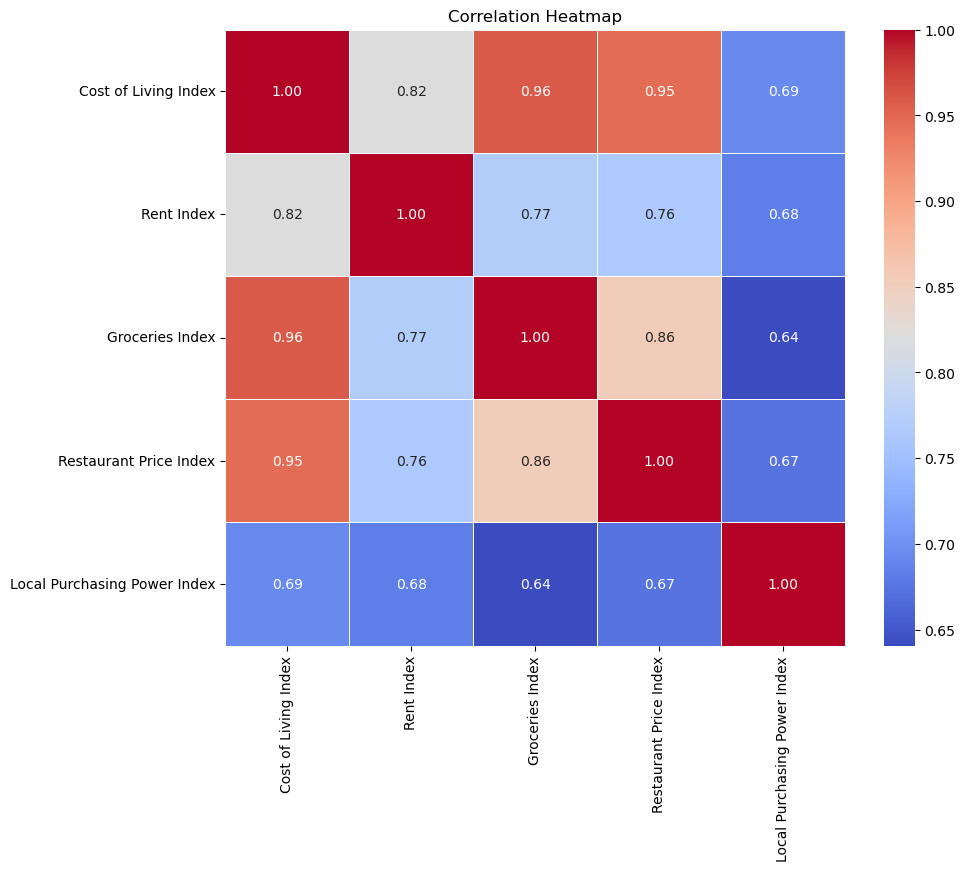

In [21]:
data_x_variables = data.drop(['Rank','Country','Country_1', 'Cost of Living Plus Rent Index'], axis=1)
data_corr = data_x_variables.corr()
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### based on heat map result cost of living index with rent, groceries and restaturant price indexes has strong coreleation and moderate coreleation with local purchasing power index



## Determine optimal value of K number of cluster


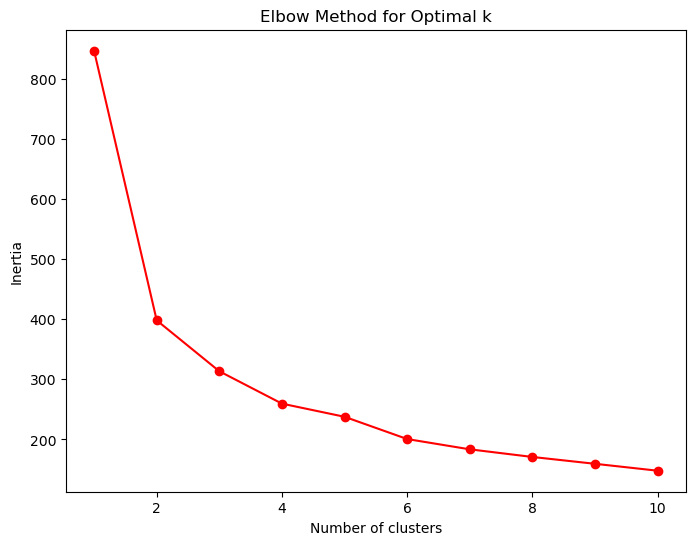

In [22]:
# Use the Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 11)  # Testing k values from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-', color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### The optimal number of clusters is 4, where the inertia starts to decrease at a slower rate. 
### At this point on the curve resembles an "elbow".

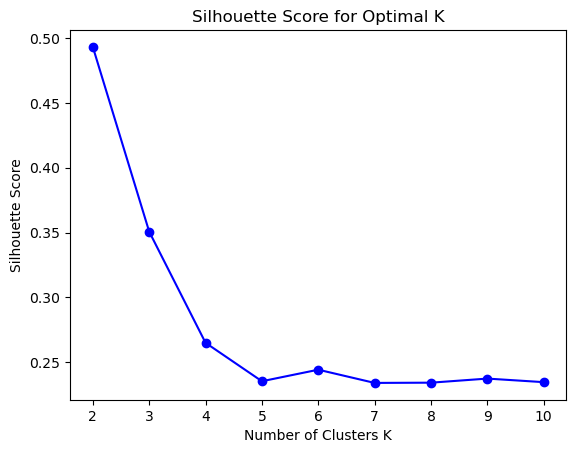

K = 2, Silhouette Score = 0.4932
K = 3, Silhouette Score = 0.3507
K = 4, Silhouette Score = 0.2649
K = 5, Silhouette Score = 0.2353
K = 6, Silhouette Score = 0.2442
K = 7, Silhouette Score = 0.2340
K = 8, Silhouette Score = 0.2342
K = 9, Silhouette Score = 0.2374
K = 10, Silhouette Score = 0.2346


In [23]:
## Compute  silhouette scores for a range of K
silhouette_scores = []
K_range = range(2, 11) # K must be aleast 2
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state =42).fit(scaled_features)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
## plot the silhouette scores
plt.plot(K_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

for k, score in zip(K_range, silhouette_scores):
    print(f'K = {k}, Silhouette Score = {score:.4f}' )
    


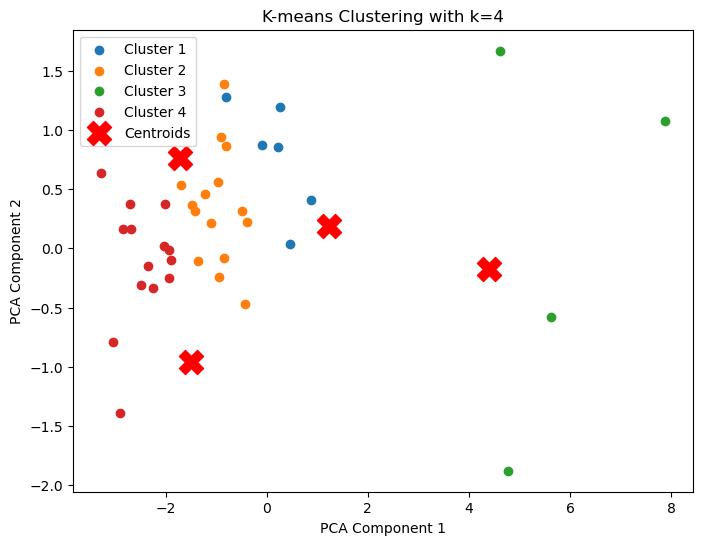

In [30]:
# Run K-means clustering with k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

# Assign cluster labels to the original data
data['Cluster'] = kmeans.labels_
centroids = kmeans.cluster_centers_

# Reduce the dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Plotting the clusters
plt.figure(figsize=(8, 6))

# Scatter plot for each cluster
for i in range(4):
    plt.scatter(pca_components[cluster_labels == i, 0], 
                pca_components[cluster_labels == i, 1], 
                label=f'Cluster {i+1}')

# Plot the centroids
centroids_2d = pca.transform(centroids)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
            s=300, c='red', label='Centroids', marker='X')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering with k=4')
plt.legend()
plt.show()

In [39]:

# Assume scaled_features is your feature matrix and labels are available
# Splitting just the features (no labels)
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)

# Dictionary to store silhouette scores
silhouette_scores = {}

# 1. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features)
silhouette_scores['PCA'] = silhouette_score(scaled_features, KMeans(n_clusters=4, random_state=42).fit_predict(X_pca))

# 2. t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(scaled_features)
silhouette_scores['t-SNE'] = silhouette_score(scaled_features, KMeans(n_clusters=4, random_state=42).fit_predict(X_tsne))

# 3. UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(scaled_features)
silhouette_scores['UMAP'] = silhouette_score(scaled_features, KMeans(n_clusters=4, random_state=42).fit_predict(X_umap))


In [40]:
# Print silhouette scores
for method, score in silhouette_scores.items():
    print(f'{method}: Silhouette Score = {score:.4f}')

PCA: Silhouette Score = 0.2816
t-SNE: Silhouette Score = 0.2762
UMAP: Silhouette Score = 0.2742


# Different dimensionality reduction techniques  with Silhouette Score

### PCA (0.2816): Has the highest silhouette score, indicating that it provides the best cluster separation among the three methods. Since PCA is a linear technique, it might be capturing the essential linear relationships in your data better than the other methods.

### t-SNE (0.2762): Slightly lower than PCA, t-SNE is still performing well but might not be capturing the global structure of the clusters as effectively as PCA. t-SNE is known for preserving local structures, which could explain the slightly lower score.

### UMAP (0.2742): UMAP, while close in performance to t-SNE, has the lowest silhouette score. UMAP is generally good at preserving both local and global structures, but in this case, PCA seems to be more effective.

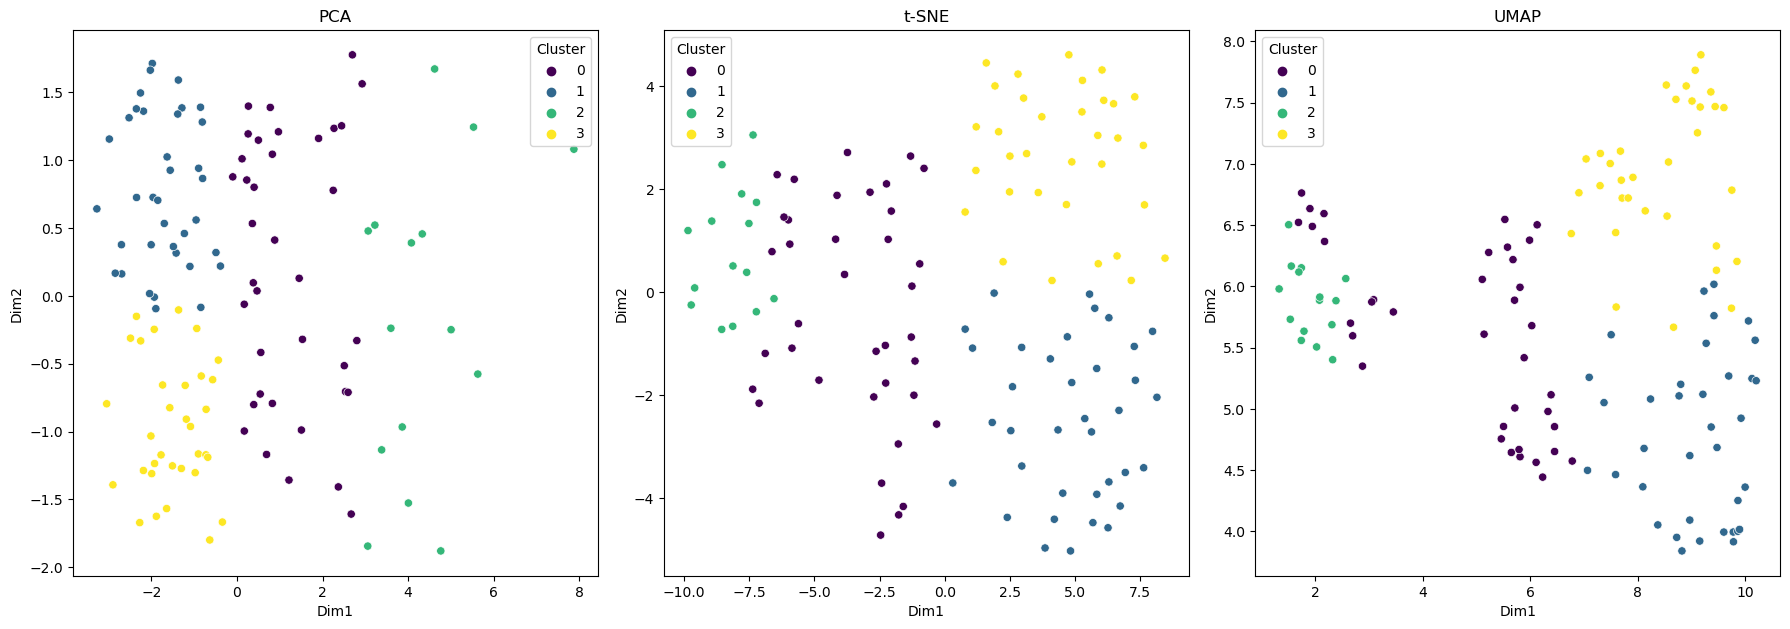

In [43]:
# Initialize different dimensionality reduction methods
methods = {
    'PCA': PCA(n_components=2),
    't-SNE': TSNE(n_components=2, random_state=42),
    'UMAP': umap.UMAP(n_components=2, random_state=42),
}

# Apply K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)
features['Cluster'] = kmeans.labels_

# Plot the results of each dimensionality reduction method
plt.figure(figsize=(18, 12))

for i, (name, method) in enumerate(methods.items()):
    reduced_data = method.fit_transform(scaled_features)
    df_reduced = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
    df_reduced['Cluster'] = features['Cluster']
    
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x='Dim1', y='Dim2', hue='Cluster', palette='viridis', data=df_reduced)
    plt.title(name)

plt.tight_layout()
plt.show()

# Compare different clustering techniques:

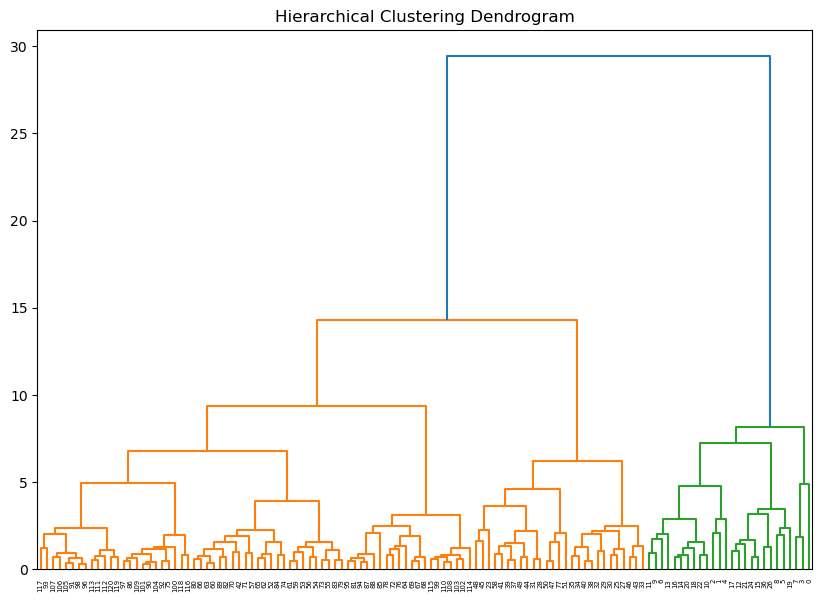

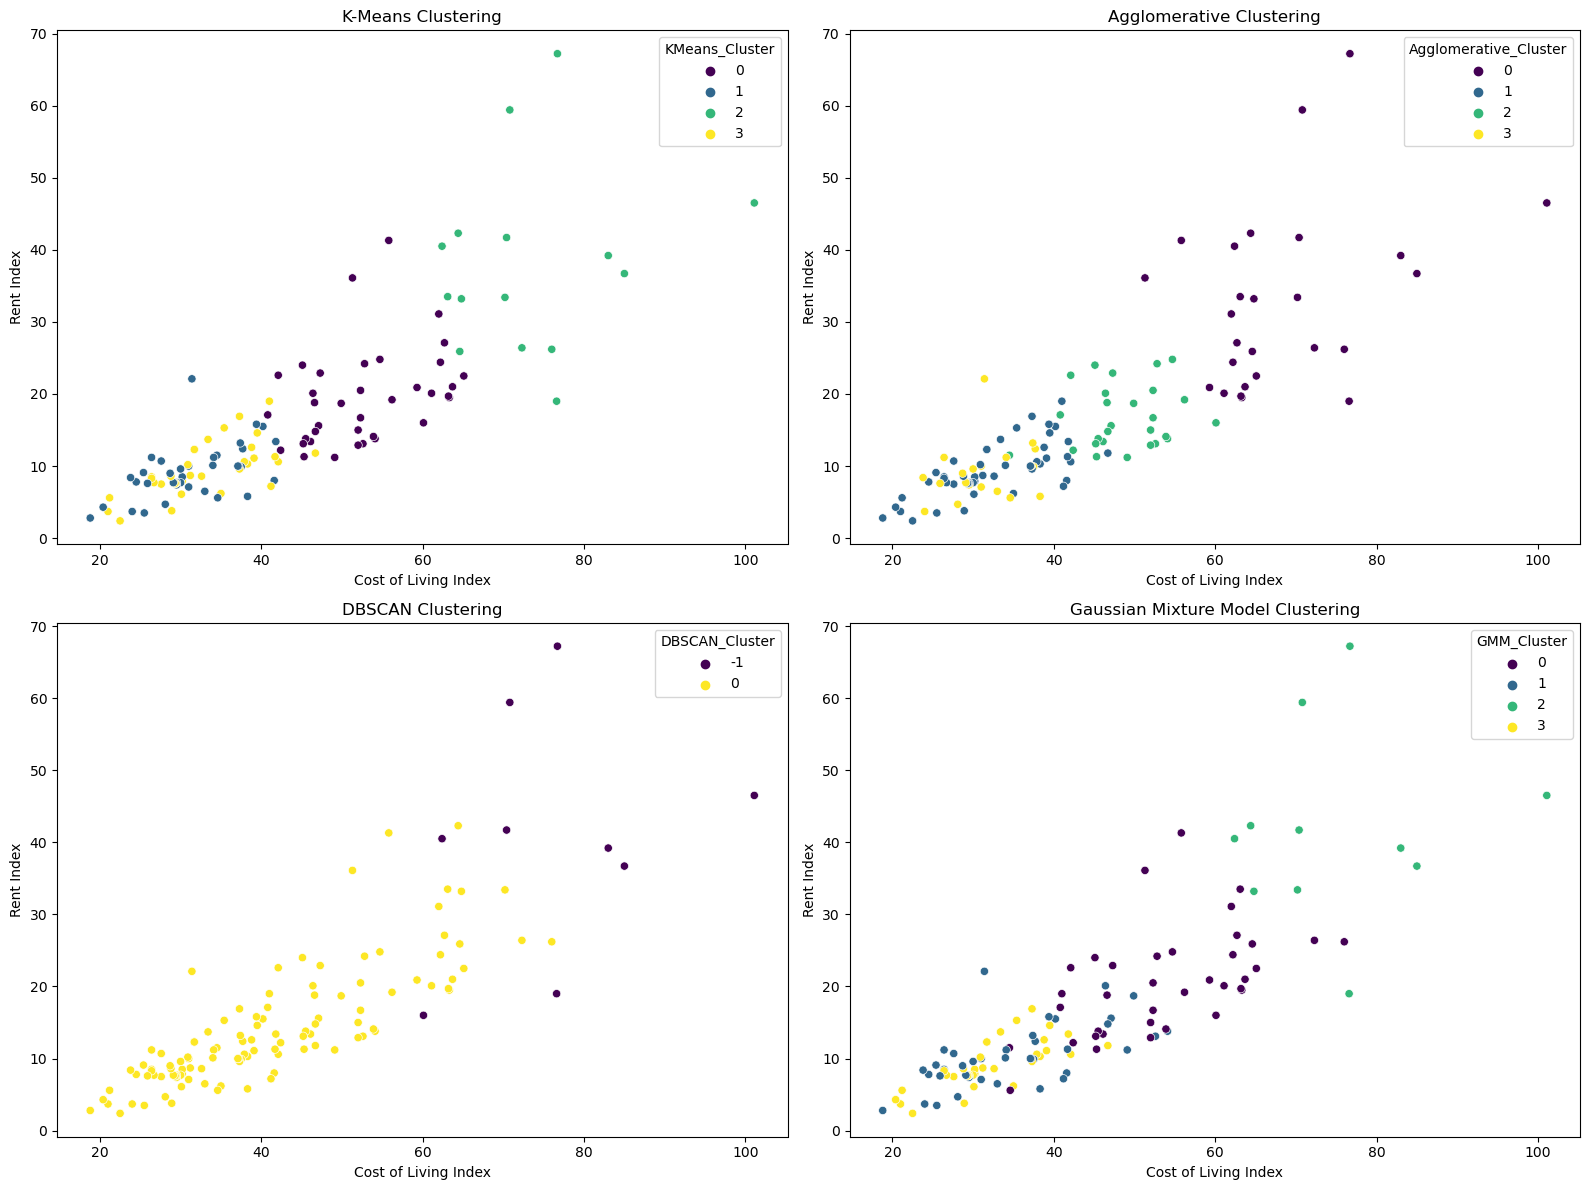

In [45]:

# 1. K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
features['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)

# 2. Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
features['Agglomerative_Cluster'] = agg_clustering.fit_predict(scaled_features)

# 3. DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=2)  # Adjust eps and min_samples as needed
features['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

# 4. Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=4, random_state=42)
features['GMM_Cluster'] = gmm.fit_predict(scaled_features)

# 5. Hierarchical Clustering (Dendrogram)
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=features.index, distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Visualization of clustering results
plt.figure(figsize=(16, 12))

# K-Means
plt.subplot(2, 2, 1)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='KMeans_Cluster', palette='viridis', data=features)
plt.title('K-Means Clustering')

# Agglomerative Clustering
plt.subplot(2, 2, 2)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='Agglomerative_Cluster', palette='viridis', data=features)
plt.title('Agglomerative Clustering')

# DBSCAN
plt.subplot(2, 2, 3)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='DBSCAN_Cluster', palette='viridis', data=features)
plt.title('DBSCAN Clustering')

# Gaussian Mixture Model
plt.subplot(2, 2, 4)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='GMM_Cluster', palette='viridis', data=features)
plt.title('Gaussian Mixture Model Clustering')

plt.tight_layout()
plt.show()

In [47]:
# Dictionary to store silhouette scores
silhouette_scores_1 = {}

# Compute silhouette scores for each method
silhouette_scores_1['K-Means'] = silhouette_score(pca_components, kmeans.labels_)
silhouette_scores_1['Agglomerative'] = silhouette_score(pca_components, features['Agglomerative_Cluster'])
silhouette_scores_1['DBSCAN'] = silhouette_score(pca_components, features['DBSCAN_Cluster'])
silhouette_scores_1['GMM'] = silhouette_score(pca_components,features['GMM_Cluster'])

# Print silhouette scores
for method, score in silhouette_scores_1.items():
    print(f'{method}: Silhouette Score = {score:.4f}')

K-Means: Silhouette Score = 0.3555
Agglomerative: Silhouette Score = 0.3317
DBSCAN: Silhouette Score = 0.4562
GMM: Silhouette Score = 0.2270


 ## DBSCAN (0.4562) is the best-performing clustering technique based on the silhouette score. It effectively identifies clusters with varying shapes and densities and handles noise better.

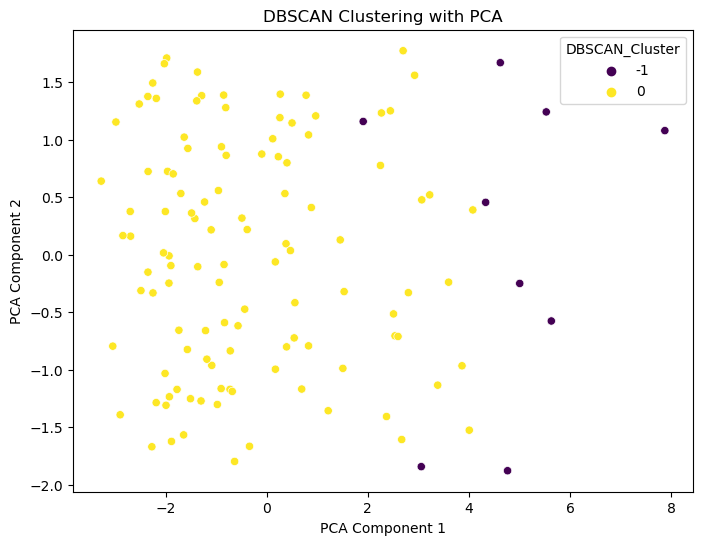

In [57]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
# Apply DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=10)
dbscan_labels = dbscan.fit_predict(pca_components)
# Plotting DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=features['DBSCAN_Cluster'], palette='viridis')
plt.title('DBSCAN Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

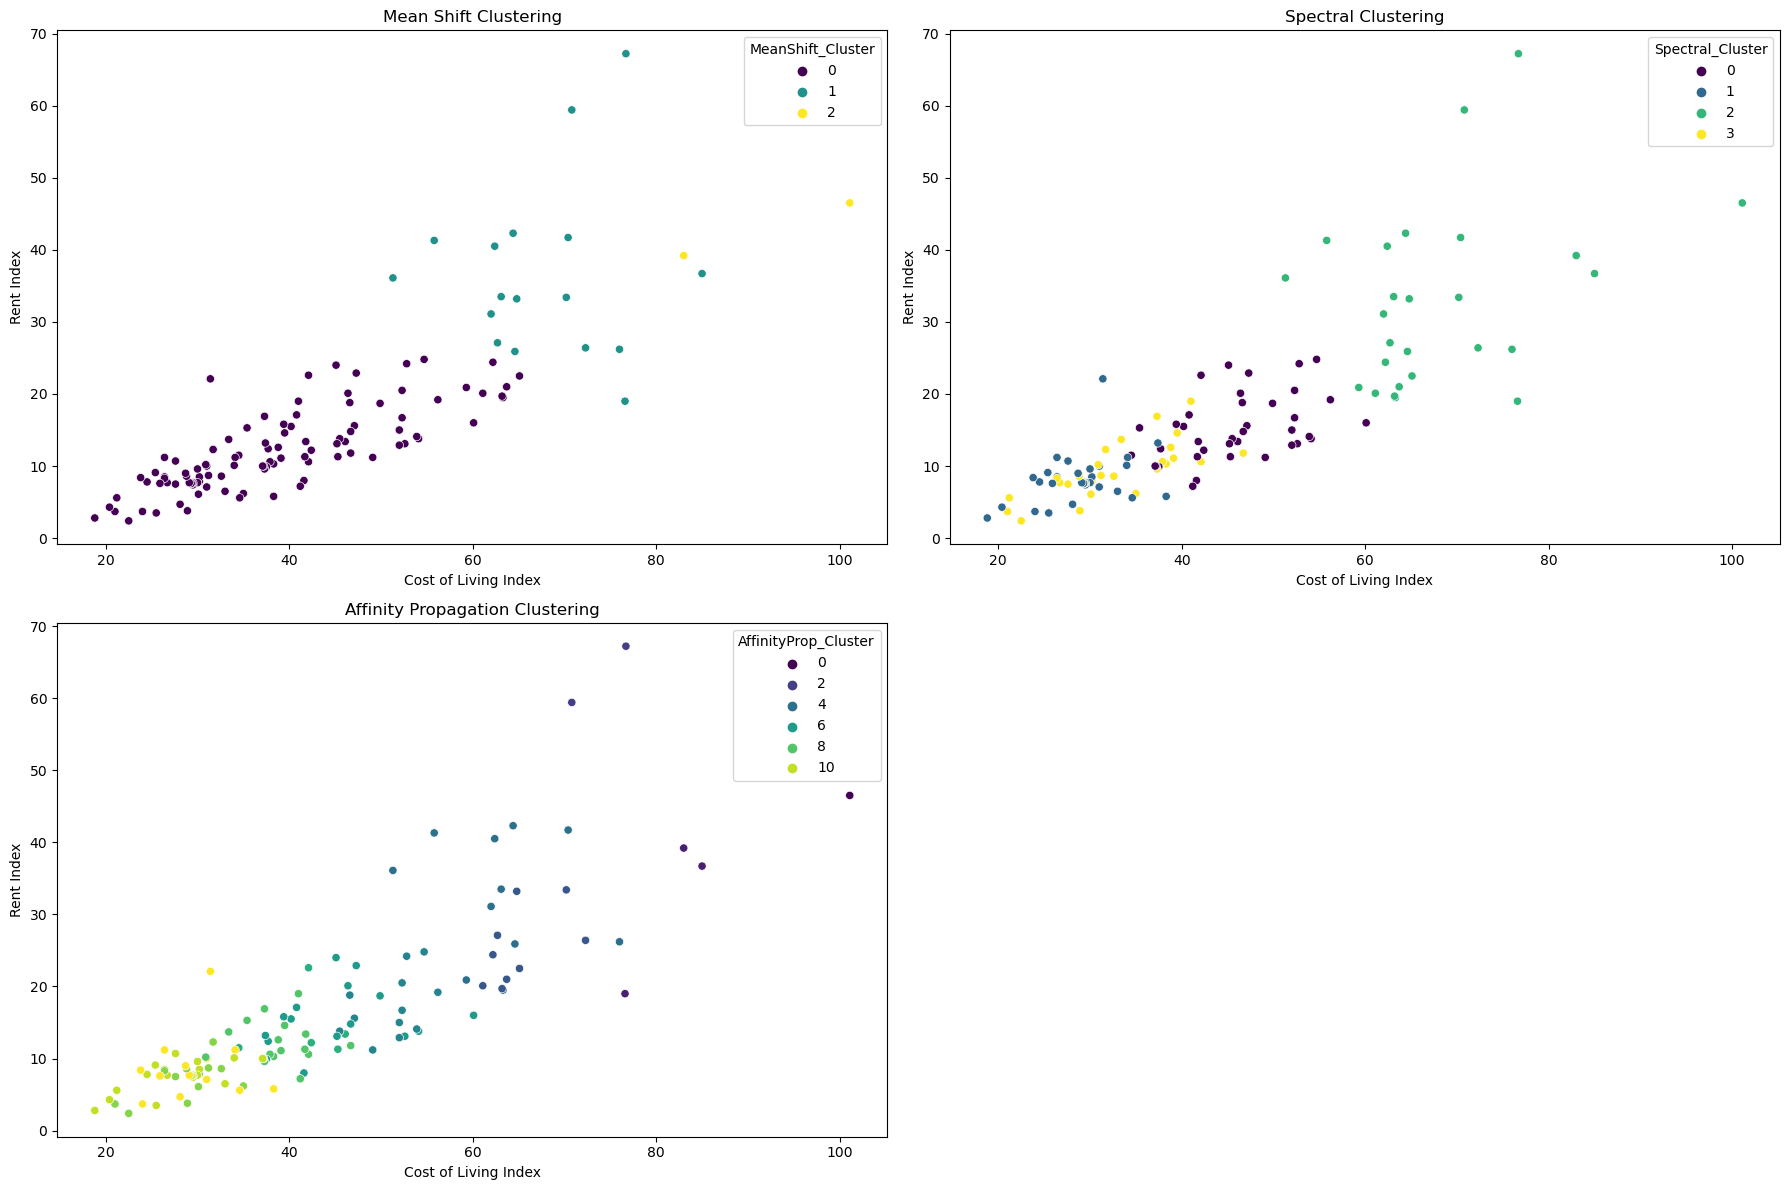

In [35]:
# 1. Mean Shift Clustering
mean_shift = MeanShift()
features['MeanShift_Cluster'] = mean_shift.fit_predict(scaled_features)

# 2. Spectral Clustering
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
features['Spectral_Cluster'] = spectral.fit_predict(scaled_features)

# 3. Affinity Propagation
affinity_prop = AffinityPropagation(random_state=42)
features['AffinityProp_Cluster'] = affinity_prop.fit_predict(scaled_features)


# Visualization of clustering results
plt.figure(figsize=(18, 12))

# Mean Shift
plt.subplot(2, 2, 1)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='MeanShift_Cluster', palette='viridis', data=features)
plt.title('Mean Shift Clustering')

# Spectral Clustering
plt.subplot(2, 2, 2)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='Spectral_Cluster', palette='viridis', data=features)
plt.title('Spectral Clustering')

# Affinity Propagation
plt.subplot(2, 2, 3)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='AffinityProp_Cluster', palette='viridis', data=features)
plt.title('Affinity Propagation Clustering')


plt.tight_layout()
plt.show()